<a href="https://colab.research.google.com/github/kdilanperera/Deep-Learning-with-fashion_mnist-model-comparison/blob/Master/inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
train_dir = '/content/data/train'
validation_dir = '/content/data/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')  # with data augmentation for train set

valid_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation for validation set

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


validation_generator = valid_datagen.flow_from_directory(validation_dir,
                                                         batch_size=100,
                                                         class_mode='categorical',
                                                         target_size=(150, 150))

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.99 and logs.get('val_acc') > 0.99):
            print("\nCancelling training as model has reached 99% accuracy and 99% validation accuracy!")
            self.model.stop_training = True

In [ ]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

In [ ]:
# Download Inception v3 weights to local machine
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import Inception v3 Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

# Load Inception v3 weights into model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights_file)

--2022-12-08 06:13:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   111MB/s    in 0.8s    

2022-12-08 06:13:56 (111 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = False

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

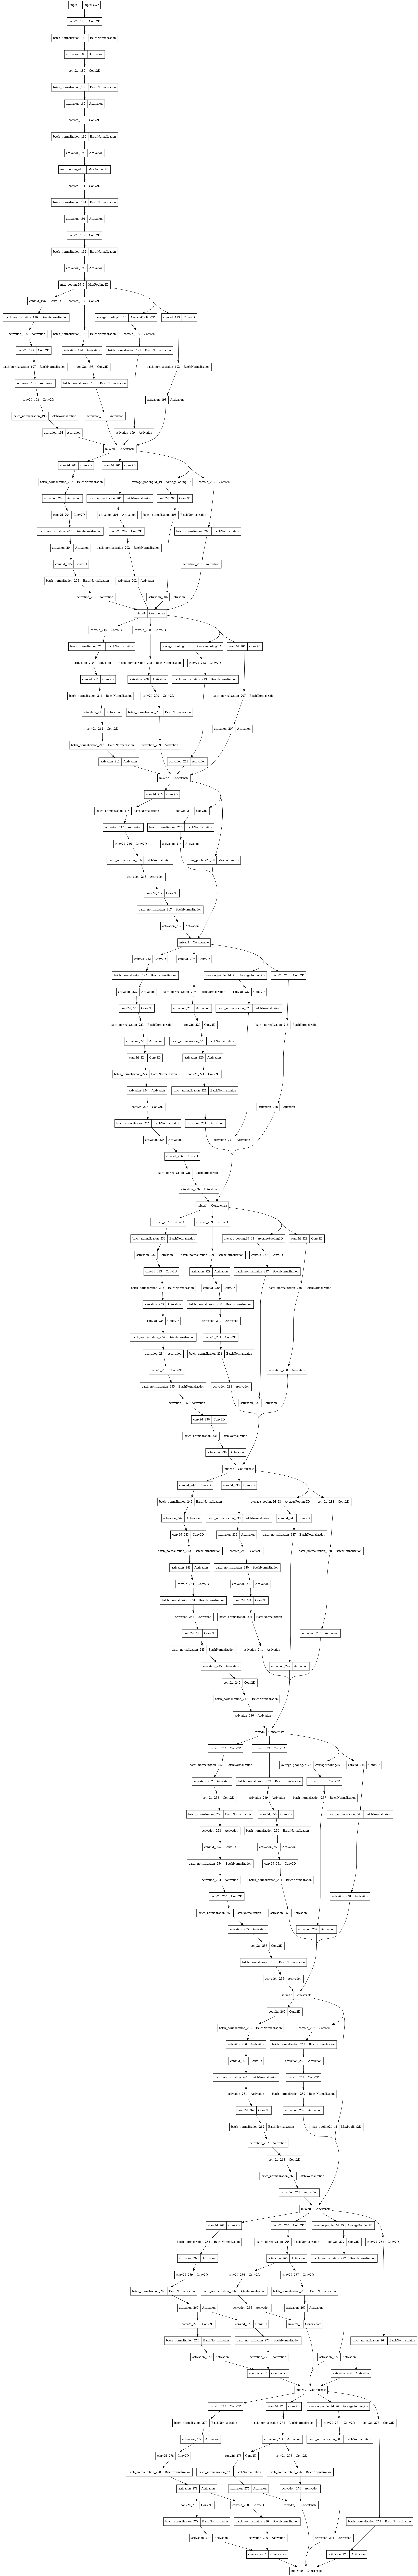

In [ ]:
pre_trained_model.summary()
plot_model(pre_trained_model, to_file='inception_v3_model.png', show_shapes=False, show_layer_names=True)

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

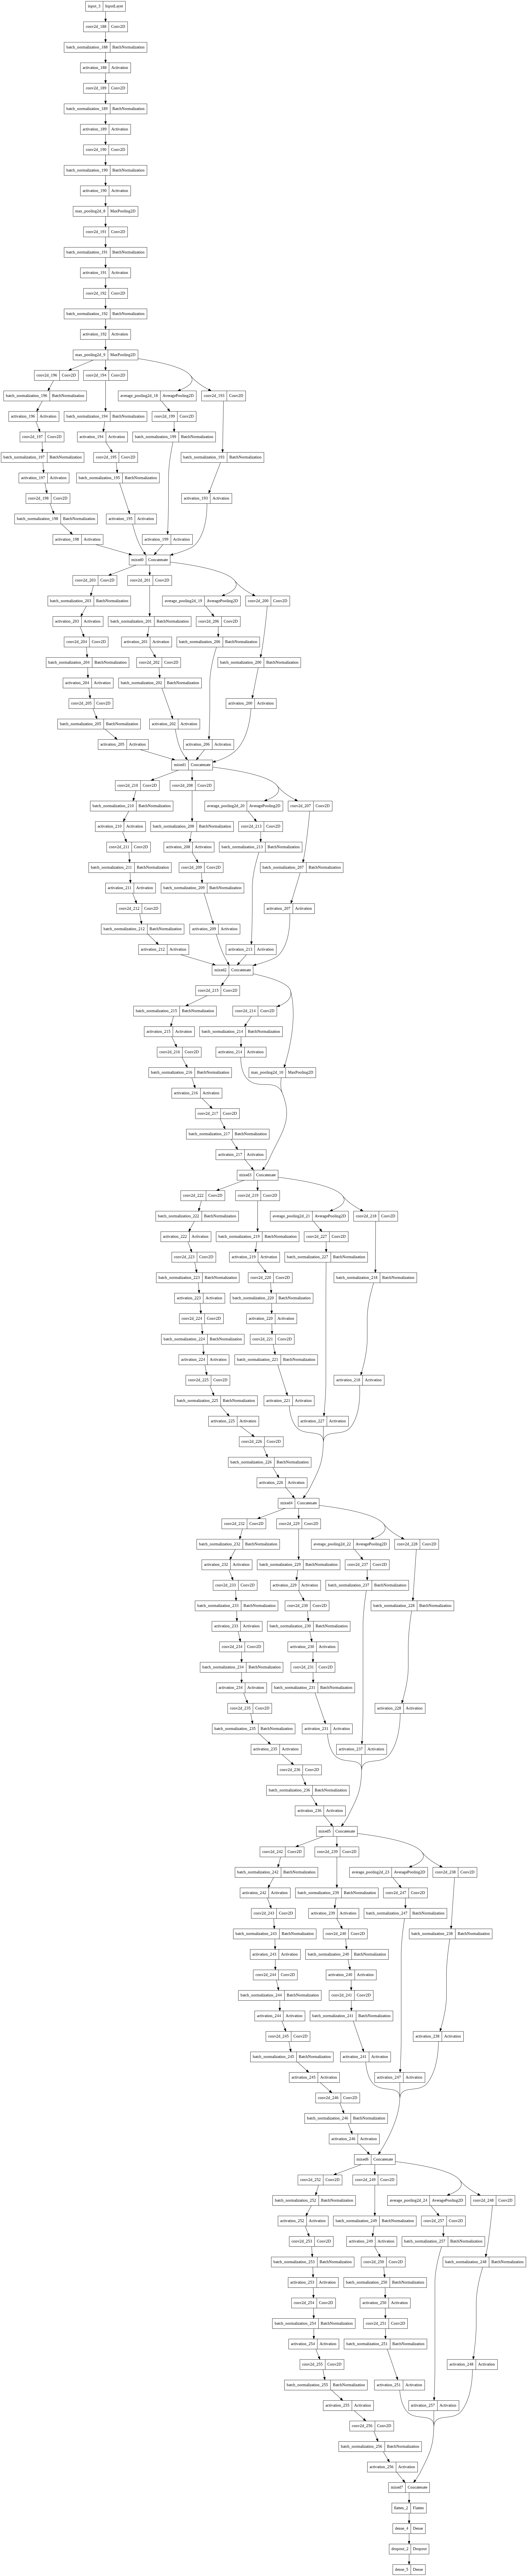

In [ ]:
model.summary()
plot_model(model, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)

In [ ]:
# Train the Model
callbacks = myCallback()
# history = model.fit(
#     train_features_flat,
#     train_label,
#     epochs=10,
#     validation_data=(val_features_flat, valid_label),
#     callbacks=callbacks
# )

In [ ]:
history = model.fit_generator(generator = train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_steps=100,
                              verbose=2,
                              callbacks=[callbacks])

<ipython-input-46-b8b7f13a14f9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


Epoch 1/10


InvalidArgumentError: ignored